# Wrangling FSA Shape Files with GeoPandas
Author: Jennifer Hoang

Date: 2022-01-24

The Forward Sortation Area (FSA) is used to describe a major geographic area within a Canadian province and forms the first 3 characters of the postal code.

I want to use the FSA geographic boundaries to create a choropleth (filled) map in Looker by uploading the geospatial data to BigQuery. This notebook details the data wrangling steps used.

**Data Source:**

The 2021 Census Forward Sortation Area Boundary files were downloaded from Statistics Canada [here](https://www150.statcan.gc.ca/n1/en/catalogue/92-179-X). Note: This data source uses the Lambert projection as [mentioned here](https://www150.statcan.gc.ca/n1/pub/92-179-g/92-179-g2021001-eng.htm). BigQuery only accepts Geography data using the WGS84 coordinate reference system (CRS) [source](https://cloud.google.com/bigquery/docs/geospatial-data), so we'll need to convert the CRS.

In [1]:
import geopandas as gpd
import pandas as pd

# Import FSA shape file
data = gpd.read_file('../data/FSA Data/lfsa000b21a_e/lfsa000b21a_e.shp')
data.info()

# Import FSA-City Mapping 
fsa_list = pd.read_csv('../data/FSA Data/FSA_List.csv')
fsa_list.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1643 entries, 0 to 1642
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   CFSAUID   1643 non-null   object  
 1   DGUID     1643 non-null   object  
 2   PRUID     1643 non-null   object  
 3   PRNAME    1643 non-null   object  
 4   LANDAREA  1643 non-null   float64 
 5   geometry  1643 non-null   geometry
dtypes: float64(1), geometry(1), object(4)
memory usage: 77.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 940 entries, 0 to 939
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   FSA        940 non-null    object
 1   Type       940 non-null    object
 2   Area Code  441 non-null    object
dtypes: object(3)
memory usage: 22.2+ KB


In [2]:
data.head()

,CFSAUID,DGUID,PRUID,PRNAME,LANDAREA,geometry
0,A0A,2021A0011A0A,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,4136.6221,"MULTIPOLYGON (((8986398.603 2027249.146, 89863..."
1,A0B,2021A0011A0B,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,4152.6284,"MULTIPOLYGON (((8942820.023 2019517.649, 89428..."
2,A0C,2021A0011A0C,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,2733.4722,"MULTIPOLYGON (((8881604.920 2158976.151, 88816..."
3,A0E,2021A0011A0E,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,6365.8235,"MULTIPOLYGON (((8824262.857 1952006.689, 88242..."
4,A0G,2021A0011A0G,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,15499.6047,"MULTIPOLYGON (((8847567.966 2181504.514, 88475..."


### Filter for Ontario FSAs and Select Columns

In [3]:
# Query for FSA data in Ontario & Select Columns
on_data = data.query('PRNAME == "Ontario"')[['CFSAUID', 'geometry']]

# Rename CFSAUID to FSA
on_data = on_data.rename(columns={'CFSAUID': 'FSA'})

<AxesSubplot: >

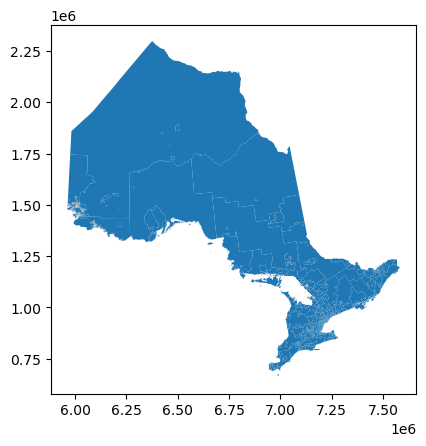

In [4]:
on_data.plot()

### Convert Coordinate Reference System to WGS84

In [5]:
on_data = on_data.to_crs(crs = 'WGS84')

<AxesSubplot: >

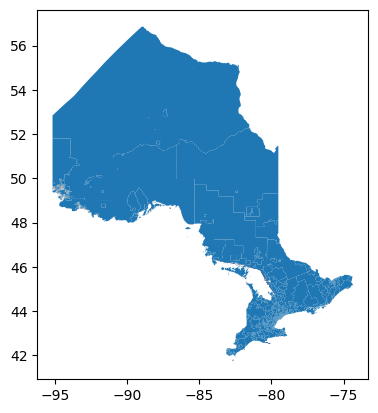

In [6]:
on_data.plot()

### Join Geometry with FSA-City Mapping Data

In [7]:
fsa_join = gpd.GeoDataFrame(fsa_list
    .query('Type != "Not assigned" & Type != "Not in use"')
    .merge(on_data, how='left', on='FSA')
    .drop(columns='Area Code')
)

### Write to GeoJSON and Convert to GeoJSONL

BigQuery can import JSON files but only in the Newline Delimiter JSON format. We will write to GeoJSON first then convert to Newline delimited format, GeoJSONL, using the `ogr2ogr` converter from GDAL (install using Conda). [(Source)](https://medium.com/google-cloud/import-gis-data-into-bigquery-8217dc370040)

In [8]:
# Write to GeoJSON File
fsa_join.to_file('../data/FSA Data/FSA_ON_join.geojson', driver= "GeoJSON")

In [9]:
# Convert geojson to geojsonl:
! ogr2ogr -f "GeoJSONSeq" "../data/FSA Data/FSA_ON_join.geojsonl" "../data/FSA Data/FSA_ON_join.geojson"

In [10]:
# Load Data into BigQuery using bq:
# ! bq load --source_format=NEWLINE_DELIMITED_JSON --json_extension=GEOJSON --autodetect dispatches.fsa_geo '../data/FSA Data/FSA_ON_join.geojsonl'

Note on Simplifying Geometries:
- I would suggest using the `simplify` function in `geopandas` to simplify the geometries, or using the `ST_SIMPLIFY` function in BigQuery. (I used a tolerance of 10 meters.) 
- Looker can only display a limited number of polygon vertices, so you may find that some polygons are not displayed if the geometries are too complex. Simplifying the polygons also speeds up the dashboard performance.